<a href="https://colab.research.google.com/github/ShokulSet/DTPDC-DigitalTextilePrintingDefectClassification/blob/main/train.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

<h1><b>Download dataset and spliting for train and validation.

In [1]:
%pip install torchvision
%pip install pytorch-lightning
%pip install -U --no-cache-dir gdown --pre

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 720.6/720.6 kB 25.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 519.2/519.2 kB 38.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.0/1.0 MB 60.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 114.5/114.5 kB 15.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 268.8/268.8 kB 31.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 149.6/149.6 kB 16.8 MB/s eta 0:00:00
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Attempting uninstall: gdown
    Found existing installation: gdown 4.6.6
    Uninstalling gdown-4.6.6:
      Successfully uninstalled gdown-4.6.6


In [2]:
import os
import os.path as op
import shutil
from glob import glob
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from tqdm.auto import tqdm

from torchvision import datasets, models, transforms
import torchvision.transforms as T
from torch.utils.data import DataLoader
from sklearn.model_selection import train_test_split

import torch
import torch.nn as nn
import pytorch_lightning as pl
from torchmetrics import Accuracy
import torch.nn.functional as F
from pytorch_lightning.callbacks import ModelCheckpoint
from torch.utils.data import Subset
from torchmetrics.functional import accuracy
from PIL import Image
import gdown

In [3]:
#Get data from google drive
!gdown 1-MvMBJnrn-I6iZK7qh4tc6iMrjgQ8YjC
!unzip data.zip

Downloading...
From (uriginal): https://drive.google.com/uc?id=1-MvMBJnrn-I6iZK7qh4tc6iMrjgQ8YjC
From (redirected): https://drive.google.com/uc?id=1-MvMBJnrn-I6iZK7qh4tc6iMrjgQ8YjC&confirm=t&uuid=3cd49a30-9b6f-4ed6-9843-2796fd0be308
To: /content/data.zip
100% 952M/952M [00:16<00:00, 58.5MB/s]
Archive:  data.zip
   creating: data/img/
   creating: data/img/test/
   creating: data/img/test/Defect/
  inflating: data/img/test/Defect/20230410_133358.jpg  
  inflating: data/img/test/Defect/20230410_133454.jpg  
  inflating: data/img/test/Defect/20230410_142437.jpg  
  inflating: data/img/test/Defect/20230410_143606.jpg  
  inflating: data/img/test/Defect/20230410_143802.jpg  
  inflating: data/img/test/Defect/20230426_124721.jpg  
  inflating: data/img/test/Defect/20230426_145401.jpg  
  inflating: data/img/test/Defect/20230426_145559.jpg  
  inflating: data/img/test/Defect/20230426_145802.jpg  
  inflating: data/img/test/Defect/20230426_145819.jpg  
   creating: data/img/test/nDefect/
  inf

In [4]:
#Counting how many pictures are there
c = 0
for file in glob('data/img/*/*/*.jpg'):
    c +=1
print(f"There are {c} pictures.")

There are 273 pictures.


In [5]:
#Create pandas data frame
train_path = []
train_id = []
train_label = []

test_path = []
test_id = []
test_label = []

for file in glob('data/img/train/*/*.jpg'):
        train_path.append(file)
        train_id.append(file.split("/")[-1][0:-4])
        train_label.append(file.split("/")[-2])

for file in glob('data/img/test/*/*.jpg'):
        test_path.append(file)
        test_id.append(file.split("/")[-1][0:-4])
        test_label.append(file.split("/")[-2])

train_df = pd.DataFrame({
    'path' : train_path,
    'id' : train_id,
    'label' : train_label
})

test_df = pd.DataFrame({
    'path' : test_path,
    'id' : test_id,
    'label' : test_label
})


In [6]:
train_df

,path,id,label
0,data/img/train/Defect/20230426_124741.jpg,20230426_124741,Defect
1,data/img/train/Defect/20230410_143633.jpg,20230410_143633,Defect
2,data/img/train/Defect/20230426_145844.jpg,20230426_145844,Defect
3,data/img/train/Defect/20230426_150003.jpg,20230426_150003,Defect
4,data/img/train/Defect/20230426_125054.jpg,20230426_125054,Defect
...,...,...,...
248,data/img/train/nDefect/20230410_130124.jpg,20230410_130124,nDefect
249,data/img/train/nDefect/20230410_131348.jpg,20230410_131348,nDefect
250,data/img/train/nDefect/20230410_125916.jpg,20230410_125916,nDefect
251,data/img/train/nDefect/20230410_130100.jpg,20230410_130100,nDefect


In [7]:
test_df

,path,id,label
0,data/img/test/Defect/20230426_145819.jpg,20230426_145819,Defect
1,data/img/test/Defect/20230426_145401.jpg,20230426_145401,Defect
2,data/img/test/Defect/20230426_145802.jpg,20230426_145802,Defect
3,data/img/test/Defect/20230410_133358.jpg,20230410_133358,Defect
4,data/img/test/Defect/20230426_145559.jpg,20230426_145559,Defect
5,data/img/test/Defect/20230410_133454.jpg,20230410_133454,Defect
6,data/img/test/Defect/20230410_142437.jpg,20230410_142437,Defect
7,data/img/test/Defect/20230410_143802.jpg,20230410_143802,Defect
8,data/img/test/Defect/20230410_143606.jpg,20230410_143606,Defect
9,data/img/test/Defect/20230426_124721.jpg,20230426_124721,Defect


In [8]:
#Randomly spliting images for  train and validation 
train_df, validation_df = train_test_split(train_df, test_size=0.1, random_state=3)
print("Length of training set = {}, validation set = {}, test set = {}".format(len(train_df), len(validation_df), len(test_df)))


Length of training set = 227, validation set = 26, test set = 20


In [9]:
#Mixed all thing into train folder
root_dir = "train/"
for df, f in zip([train_df, validation_df, test_df], ["train", "validation", "test"]):
    for _, r in df.iterrows():
        # create subfolder if it doesn't exist
        d = op.join(root_dir, f, r.label)
        if not op.exists(d):
            os.makedirs(d)
        shutil.copy(r.path, op.join(root_dir, f, r.label, f"{r.id}.jpg"))

<h1><b>Train a model

In [10]:
train_transform = T.Compose([
    T.Resize((224, 224)),
    T.RandomHorizontalFlip(p=0.2),
    T.RandomResizedCrop((224, 224)),
    # T.Grayscale(3),
    T.ToTensor(),
])
val_transform = T.Compose([
    T.Resize((224, 224)),
    # T.Grayscale(3),
    T.ToTensor(),
])


In [11]:
train_data = datasets.ImageFolder("train/train/", transform=train_transform)
val_data = datasets.ImageFolder("train/validation/", transform=val_transform)
test_data = datasets.ImageFolder("train/test/", transform=val_transform)

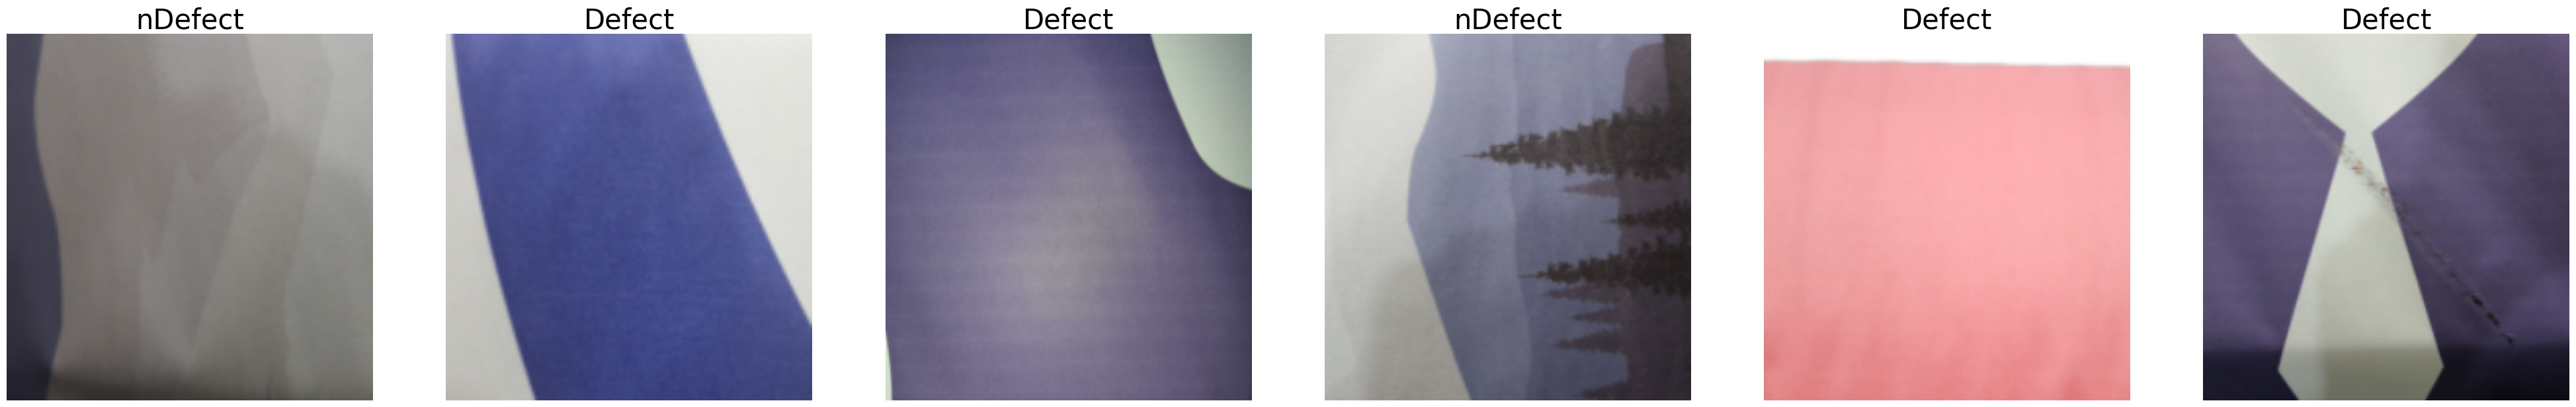

In [12]:
#Showing some images form train and validation and test set from Defect and Non defect and label it
from random import randint
fig, ax = plt.subplots(1, 6, figsize=(50, 45))
for j in range(6):
    img, label = train_data[randint(0,len(train_data))]
    ax[j].imshow(img.permute(1, 2, 0))
    ax[j].set_title(label = train_data.classes[label], fontsize = 30)
    ax[j].axis("off")
plt.show()


In [13]:
train_loader = DataLoader(train_data, batch_size=32, shuffle=True)
val_loader = DataLoader(val_data, batch_size=32, shuffle=False)
test_loader = DataLoader(test_data, batch_size=32, shuffle=False)

In [14]:
classes = train_data.classes
n_classes = len(classes)
print(f"There are {n_classes}, which is {classes}")

There are 2, which is ['Defect', 'nDefect']


In [15]:
class DefectResNet(pl.LightningModule):
    def __init__(self, n_classes=2):
        super(DefectResNet, self).__init__()
        
        # จำนวนของพันธุ์output (2)
        self.n_classes = n_classes

        #เปลี่ยน layer สุดท้าย
        self.backbone = models.resnet50(pretrained=True)
        # self.backbone = models.resnet152(pretrained=True)
        # self.backbone = models.vgg19(pretrained=True)
        for param in self.backbone.parameters():
            param.requires_grad = False

        # เปลี่ยน fc layer เป็น output ขนาด 2
        self.backbone.fc = torch.nn.Linear(self.backbone.fc.in_features, n_classes) #For ResNet base mdoel
        # self.backbone.classifier[6] = torch.nn.Linear(self.backbone.classifier[6].in_features, n_classes) #For VGG bse model
        
        self.entropy_loss = nn.CrossEntropyLoss()
        self.accuracy = Accuracy(task="multiclass", num_classes=2)

        self.save_hyperparameters(logger=False)

    def forward(self, x):
        preds = self.backbone(x)
        return preds

    def training_step(self, batch, batch_idx):
        x, y = batch
        logits = self.backbone(x)
        loss = self.entropy_loss(logits, y)
        y_pred = torch.argmax(logits, dim=1)
        self.log("train_loss", loss)
        self.log("train_acc", self.accuracy(y_pred, y))
        return loss

    def validation_step(self, batch, batch_idx):
        x, y = batch
        logits = self.backbone(x)
        loss = self.entropy_loss(logits, y)
        y_pred = torch.argmax(logits, dim=1)
        self.log("val_loss", loss)
        self.log("val_acc", self.accuracy(y_pred, y))
        return loss
        
    def configure_optimizers(self):
        self.optimizer = torch.optim.AdamW(self.parameters(), lr=1e-3)
        return {
            "optimizer": self.optimizer,
            "monitor": "val_loss",
        }

    def test_step(self, batch, batch_idx):
        x, y = batch
        logits = self.backbone(x)
        loss = self.entropy_loss(logits, y)
        y_pred = torch.argmax(logits, dim=1)
        self.log("val_loss", loss)
        self.log("val_acc", self.accuracy(y_pred, y))
        return loss
    
    def _shared_eval_step(self, batch, batch_idx):
        x, y = batch
        y_hat = self.model(x)
        logits = self.backbone(x)
        loss = self.entropy_loss(logits, y)
        acc = accuracy(y_hat, y)
        return loss, acc

In [16]:
model = DefectResNet(n_classes=n_classes)

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet50-0676ba61.pth" to /root/.cache/torch/hub/checkpoints/resnet50-0676ba61.pth
100%|██████████| 97.8M/97.8M [00:00<00:00, 244MB/s]


In [17]:
checkpoint_callback = ModelCheckpoint(
   dirpath="checkpoints/",
   filename="model--{epoch:02d}-{val_acc:.2f}-{val_loss:.2f}",
   save_top_k=-1,
   verbose=True,
   monitor="val_loss",
   mode="min",
)

In [18]:
trainer = pl.Trainer(max_epochs=6, callbacks=[checkpoint_callback], accelerator="gpu")
trainer.fit(model, train_dataloaders=train_loader, val_dataloaders=val_loader)

INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:IPU available: False, using: 0 IPUs
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:pytorch_lightning.callbacks.model_summary:
  | Name         | Type               | Params
----------------------------------------------------
0 | backbone     | ResNet             | 23.5 M
1 | entropy_loss | CrossEntropyLoss   | 0     
2 | accuracy     | MulticlassAccuracy | 0     
----------------------------------------------------
4.1 K     Trainable params
23.5 M    Non-trainable params
23.5 M    Total params
94.049    Total estimated model params size (MB)


Sanity Checking: 0it [00:00, ?it/s]

/usr/local/lib/python3.10/dist-packages/pytorch_lightning/loops/fit_loop.py:280: PossibleUserWarning: The number of training batches (8) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.
  rank_zero_warn(


Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:Epoch 0, global step 8: 'val_loss' reached 0.67526 (best 0.67526), saving model to '/content/checkpoints/model--epoch=00-val_acc=0.58-val_loss=0.68.ckpt' as top 1


Validation: 0it [00:00, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:Epoch 1, global step 16: 'val_loss' reached 0.51121 (best 0.51121), saving model to '/content/checkpoints/model--epoch=01-val_acc=0.85-val_loss=0.51.ckpt' as top 2


Validation: 0it [00:00, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:Epoch 2, global step 24: 'val_loss' reached 0.74133 (best 0.51121), saving model to '/content/checkpoints/model--epoch=02-val_acc=0.50-val_loss=0.74.ckpt' as top 3


Validation: 0it [00:00, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:Epoch 3, global step 32: 'val_loss' reached 0.45368 (best 0.45368), saving model to '/content/checkpoints/model--epoch=03-val_acc=0.73-val_loss=0.45.ckpt' as top 4


Validation: 0it [00:00, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:Epoch 4, global step 40: 'val_loss' reached 0.37961 (best 0.37961), saving model to '/content/checkpoints/model--epoch=04-val_acc=0.88-val_loss=0.38.ckpt' as top 5


Validation: 0it [00:00, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:Epoch 5, global step 48: 'val_loss' reached 0.33324 (best 0.33324), saving model to '/content/checkpoints/model--epoch=05-val_acc=0.92-val_loss=0.33.ckpt' as top 6
INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=6` reached.


In [20]:
trainer.test(model=model, dataloaders=test_loader)

INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Testing: 0it [00:00, ?it/s]

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│          val_acc          │            1.0            │
│         val_loss          │    0.2723885178565979     │
└───────────────────────────┴───────────────────────────┘

[{'val_loss': 0.2723885178565979, 'val_acc': 1.0}]

<h1><b>Test loading model


In [21]:
loadmodel = DefectResNet(n_classes=n_classes)

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [22]:
def load_checkpoint(checkpoint):
  loadmodel.load_state_dict(checkpoint["state_dict"])

In [24]:
load_checkpoint(torch.load("/content/checkpoints/model--epoch=05-val_acc=0.92-val_loss=0.33.ckpt"))
loadmodel.eval()

DefectResNet(
  (backbone): ResNet(
    (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
    (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (layer1): Sequential(
      (0): Bottleneck(
        (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (downsample): Sequential(
    

In [25]:
test_transform = T.Compose([
    T.Resize((224, 224)),
    T.ToTensor()
])

img_path = "/content/data/img/test/Defect/20230410_143802.jpg"
img = Image.open(img_path)
img = test_transform(img).unsqueeze(0)

def PredLoader(n):
  return F.softmax(loadmodel(img), dim=1)

In [31]:
PredLoader(0)

tensor([[0.4423, 0.5577]], grad_fn=<SoftmaxBackward0>)